# Image Classification Modeling


**Summary**


In this notebook we will develop three different kinds of image classification models to determine spectrogram images of minor and major chords.
We will start by creating a baseline convolutional neural network with two hidden layers. Our null baseline accuracy will be 58% because that is
the higher proportion of our class data. We will determine a model's success by whether or not it exceeds our null baseline and baseline model.
We will use regularization techniques to improve our baseline model, then use a VGG16 as a transfer learning method.


**In this notebook we used two kinds of mel-spectrograms**


- Original Mel-Spectrograms: tested different formatting with the original spectrograms and found that removing tick marks, labels, and colorbars yielded the best results in our models.
- Scaled-Normalized Mel-Spectrograms: Scaled the signal time-series array of each spectrogram using the z-score method of StandardScaler

**NOTE**: This notebook was written using Google Colab, which has TensorFlow pre-installed. Please make sure you have TensorFlow installed before running.

In [21]:
# Imports to visualize data, and filter through directories
import pandas as pd
import numpy as np
from numpy.random import seed
import matplotlib.pyplot as plt
import os

# Imports for CNN models
from tensorflow.keras.utils import image_dataset_from_directory, load_img, img_to_array, normalize, set_random_seed
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Rescaling
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Imports for VGG16 Model
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy

In [22]:
# Gathering image data from a Google Drive containing two folders, one for each class (major, minor)
# Collecting data and converting it into a tf.data.Dataset object consisting of a train and test set.
img_train = image_dataset_from_directory('drive/MyDrive/data',
                                         validation_split = 0.25,
                                         image_size = (128, 128),
                                         subset = 'training',
                                         color_mode='rgb',
                                         seed = 42)

img_test = image_dataset_from_directory('drive/MyDrive/data',
                                         validation_split = 0.25,
                                         image_size = (128, 128),
                                         subset = 'validation',
                                         color_mode='rgb',
                                         seed = 42)

Found 3444 files belonging to 2 classes.
Using 2583 files for training.
Found 3444 files belonging to 2 classes.
Using 861 files for validation.


In [23]:
# Gathering SCALED image data from a Google Drive containing two folders, one for each class (major, minor)
# Collecting data and converting it into a tf.data.Dataset object consisting of a train and test set.
scaled_img_train = image_dataset_from_directory('drive/MyDrive/scaled_data',
                                         validation_split = 0.25,
                                         image_size = (128, 128),
                                         subset = 'training',
                                         color_mode='rgb',
                                         seed = 42)

scaled_img_test = image_dataset_from_directory('drive/MyDrive/scaled_data',
                                         validation_split = 0.25,
                                         image_size = (128, 128),
                                         subset = 'validation',
                                         color_mode='rgb',
                                         seed = 42)

Found 2577 files belonging to 2 classes.
Using 1933 files for training.
Found 2577 files belonging to 2 classes.
Using 644 files for validation.


# CNN Base Model

In our first cnn model we will only include two hidden layers with no regularization. We want our base model to at least perform higher than our null_baseline of 58.4% accuracy.  

In [24]:
# Increasing number of filters in each Conv2D to capture more complex features
# and decreasing number of nodes in our Dense layers to focus our model on the most import features.


base_model = Sequential()

base_model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation='relu', input_shape=(128, 128, 3)))
base_model.add(MaxPooling2D(pool_size = (2, 2)))

base_model.add(Conv2D(filters = 128, kernel_size = (3, 3), activation='relu'))
base_model.add(MaxPooling2D(pool_size = (2, 2)))

base_model.add(Flatten())

base_model.add(Dense(16, activation='relu'))

base_model.add(Dense(1, activation='sigmoid'))

In [25]:
base_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 126, 126, 64)      1792      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 63, 63, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 61, 61, 128)       73856     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 30, 30, 128)       0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 115200)            0         
                                                                 
 dense_5 (Dense)             (None, 16)               

In [26]:
base_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
base = base_model.fit(img_train, validation_data=img_test, batch_size=64, epochs=20)

Epoch 1/20
81/81 [==============================] - 209s 3s/step - loss: 9.1956 - acc: 0.5447 - val_loss: 0.6890 - val_acc: 0.5726
Epoch 2/20
81/81 [==============================] - 201s 2s/step - loss: 0.6788 - acc: 0.5885 - val_loss: 0.6863 - val_acc: 0.5865
Epoch 3/20
81/81 [==============================] - 201s 2s/step - loss: 0.6565 - acc: 0.6028 - val_loss: 0.7066 - val_acc: 0.5714
Epoch 4/20
81/81 [==============================] - 221s 3s/step - loss: 0.6232 - acc: 0.6314 - val_loss: 0.7036 - val_acc: 0.5772
Epoch 5/20
81/81 [==============================] - 220s 3s/step - loss: 0.5833 - acc: 0.6671 - val_loss: 0.7831 - val_acc: 0.5621
Epoch 6/20
81/81 [==============================] - 200s 2s/step - loss: 0.5381 - acc: 0.6918 - val_loss: 0.8703 - val_acc: 0.5703
Epoch 7/20
81/81 [==============================] - 201s 2s/step - loss: 0.5066 - acc: 0.7166 - val_loss: 0.8776 - val_acc: 0.5633
Epoch 8/20
81/81 [==============================] - 221s 3s/step - loss: 0.4651 - a

## Baseline Model Performance

In [ ]:
base_model.evaluate(img_test)

27/27 [==============================] - 21s 715ms/step - loss: 2.1024 - acc: 0.6098


[2.102365493774414, 0.6097561120986938]

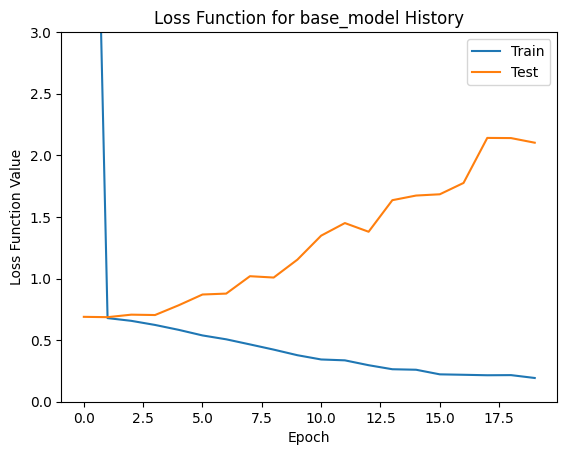

In [ ]:
plt.plot(base.history['loss'], label = 'Train')
plt.plot(base.history['val_loss'], label = 'Test')
plt.title('Loss Function for base_model History')
plt.xlabel('Epoch')
plt.ylabel('Loss Function Value')
plt.ylim(0, 3)
plt.legend();
plt.savefig('drive/MyDrive/data/loss_base.png')

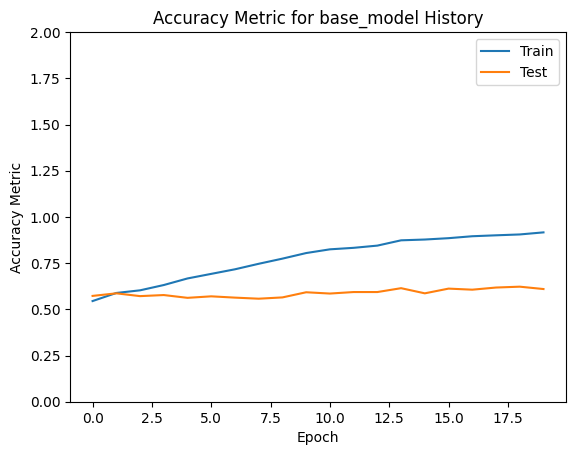

In [ ]:
plt.plot(base.history['acc'], label = 'Train')
plt.plot(base.history['val_acc'], label = 'Test')
plt.title('Accuracy Metric for base_model History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Metric')
plt.ylim(0, 2)
plt.legend();
plt.savefig('drive/MyDrive/data/acc_base.png')

# Conclusion

Although our validation data scored an accuracy of 60.89% which is roughly 2% greater than our null-baseline, our model is severely overfit because our training data scored an accuracy of 91.64% which is too great of a distance. It is also clear that our validation data's loss value grew exponentially over the epochs. This means the difference between the predicted probability and the actual binary label was getting worse and our model is not learning the different classes very well.

---

# Scaled Base Model


We will construct this model exactly like our first one but change the input data with scaled-normalized mel-spectrograms. This is to determine which kind of spectrogram formatting works the best with CNN models.


In [ ]:

sc_base_model = Sequential()

sc_base_model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation='relu', input_shape=(128, 128, 3)))
sc_base_model.add(MaxPooling2D(pool_size = (2, 2)))

sc_base_model.add(Conv2D(filters = 128, kernel_size = (3, 3), activation='relu'))
sc_base_model.add(MaxPooling2D(pool_size = (2, 2)))

sc_base_model.add(Flatten())

sc_base_model.add(Dense(16, activation='relu'))

sc_base_model.add(Dense(1, activation='sigmoid'))

In [ ]:
sc_base_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 126, 126, 64)      1792      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 63, 63, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 61, 61, 128)       73856     
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 30, 30, 128)       0         
 ng2D)                                                           
                                                                 
 flatten_5 (Flatten)         (None, 115200)            0         
                                                                 
 dense_16 (Dense)            (None, 16)               

In [ ]:
sc_base_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
sc_base = sc_base_model.fit(scaled_img_train, validation_data=scaled_img_test, batch_size=64, epochs=20)

Epoch 1/20
61/61 [==============================] - 290s 4s/step - loss: 34.6352 - acc: 0.5292 - val_loss: 0.6923 - val_acc: 0.5792
Epoch 2/20
61/61 [==============================] - 152s 2s/step - loss: 0.7246 - acc: 0.5929 - val_loss: 0.6800 - val_acc: 0.5792
Epoch 3/20
61/61 [==============================] - 153s 2s/step - loss: 0.6801 - acc: 0.5861 - val_loss: 0.6795 - val_acc: 0.5792
Epoch 4/20
61/61 [==============================] - 148s 2s/step - loss: 0.6802 - acc: 0.5861 - val_loss: 0.6802 - val_acc: 0.5792
Epoch 5/20
61/61 [==============================] - 154s 3s/step - loss: 0.6819 - acc: 0.5867 - val_loss: 0.6875 - val_acc: 0.5792
Epoch 6/20
61/61 [==============================] - 154s 3s/step - loss: 0.6812 - acc: 0.5861 - val_loss: 0.6799 - val_acc: 0.5792
Epoch 7/20
61/61 [==============================] - 154s 2s/step - loss: 0.6760 - acc: 0.5861 - val_loss: 0.6804 - val_acc: 0.5792
Epoch 8/20
61/61 [==============================] - 148s 2s/step - loss: 0.6728 - 

In [ ]:
sc_base_model.evaluate(img_test)

27/27 [==============================] - 21s 706ms/step - loss: 0.7540 - acc: 0.5877


[0.7539899945259094, 0.5876887440681458]

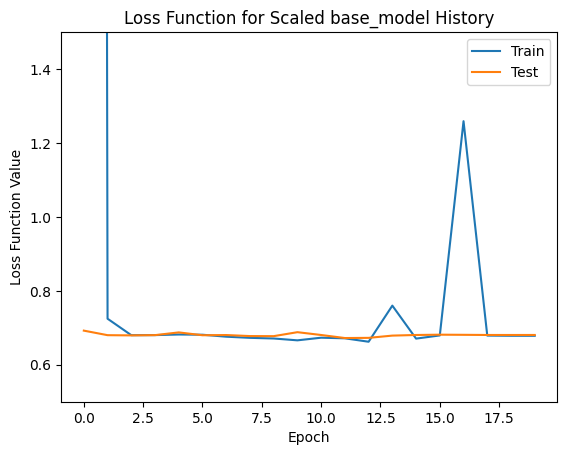

In [ ]:
plt.plot(sc_base.history['loss'], label = 'Train')
plt.plot(sc_base.history['val_loss'], label = 'Test')
plt.title('Loss Function for Scaled base_model History')
plt.xlabel('Epoch')
plt.ylabel('Loss Function Value')
plt.ylim(0.5, 1.5)
plt.legend();
plt.savefig('drive/MyDrive/data/sc_loss_base.png')

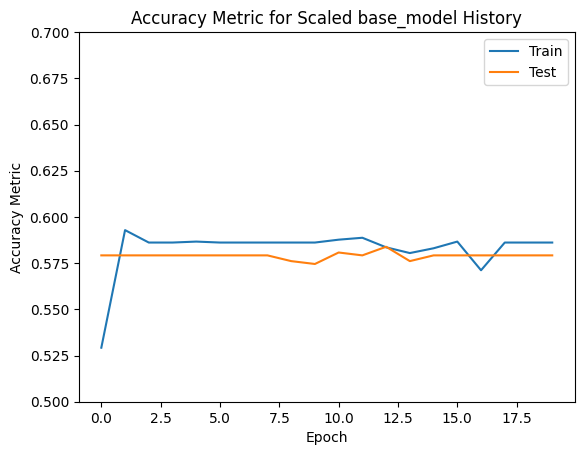

In [ ]:
plt.plot(sc_base.history['acc'], label = 'Train')
plt.plot(sc_base.history['val_acc'], label = 'Test')
plt.title('Accuracy Metric for Scaled base_model History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Metric')
plt.ylim(0.5, 0.7)
plt.legend();
plt.savefig('drive/MyDrive/data/sc_acc_base.png')

## Conclusion

This model also did not perform well to our defining success. As we can see our validation data performed with an accuracy of 58.77% which is the closest to our null baseline (58.4%) so far. Although our overall loss has decreased and improved from our first model (0.75 compared to 2.1), it is clear this model is stagnant. We can see no development or increase in accuracy and little decrease in overall loss. Incorporating scaled-normalized spectrograms did not improve our model performance.

---

# CNN model with More Layers

Although our base model showed signs of over-fitness, its poor accuracy is the most concerning. For this reason we will only add a small amount of regularization to our next model because this will penalize our weights and will impede on improving accuracy. We will add one more Conv2D and two more Dense hidden layers to allow the model to find more complex relationships in the data. We will also add an EarlyStopping with a large patience and only two dropout layers to lightly compensate the overfit base model.
For the rest of the models we will be using the original mel-spectrogram images because it performed better than the scaled data.

In [ ]:

es = EarlyStopping(patience = 10)

model_1 = Sequential()


model_1.add(Conv2D(16, kernel_size = (3, 3),
                   activation='relu'))
model_1.add(MaxPooling2D(2))

model_1.add(Conv2D(64, kernel_size = (3, 3),
                   activation='relu'))
model_1.add(MaxPooling2D(2))

model_1.add(Conv2D(128, kernel_size = (3, 3),
                   activation='relu'))
model_1.add(MaxPooling2D(2))


model_1.add(Flatten())

model_1.add(Dense(64, activation='relu'))
model_1.add(Dropout(0.05))
model_1.add(Dense(16, activation='relu'))
model_1.add(Dropout(0.2))
model_1.add(Dense(8, activation='relu'))

model_1.add(Dense(1, activation='sigmoid'))

In [ ]:
model_1.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['acc']
)

In [ ]:
model_res_1 = model_1.fit(
    img_train,
    validation_data=(img_test),
    callbacks = [es],
    batch_size=64,
    epochs=15
)

Epoch 1/15
81/81 [==============================] - 89s 1s/step - loss: 1.9702 - acc: 0.5521 - val_loss: 0.6794 - val_acc: 0.5877
Epoch 2/15
81/81 [==============================] - 97s 1s/step - loss: 0.6904 - acc: 0.5447 - val_loss: 0.6815 - val_acc: 0.5877
Epoch 3/15
81/81 [==============================] - 87s 1s/step - loss: 0.6868 - acc: 0.5614 - val_loss: 0.6834 - val_acc: 0.5877
Epoch 4/15
81/81 [==============================] - 98s 1s/step - loss: 0.6859 - acc: 0.5707 - val_loss: 0.6830 - val_acc: 0.5877
Epoch 5/15
81/81 [==============================] - 97s 1s/step - loss: 0.6843 - acc: 0.5753 - val_loss: 0.6805 - val_acc: 0.5877
Epoch 6/15
81/81 [==============================] - 96s 1s/step - loss: 0.6817 - acc: 0.5784 - val_loss: 0.6803 - val_acc: 0.5877
Epoch 7/15
81/81 [==============================] - 85s 1s/step - loss: 0.6810 - acc: 0.5811 - val_loss: 0.6795 - val_acc: 0.5865
Epoch 8/15
81/81 [==============================] - 87s 1s/step - loss: 0.6789 - acc: 0.58

In [ ]:
model_1.evaluate(img_test)

27/27 [==============================] - 9s 300ms/step - loss: 0.6741 - acc: 0.6016


[0.6741302609443665, 0.6016260385513306]

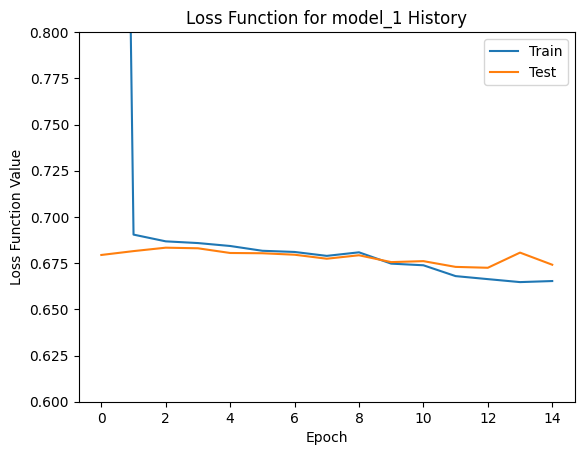

In [ ]:
plt.plot(model_res_1.history['loss'], label = 'Train')
plt.plot(model_res_1.history['val_loss'], label = 'Test')
plt.title('Loss Function for model_1 History')
plt.xlabel('Epoch')
plt.ylabel('Loss Function Value')
plt.ylim(0.6, 0.8)
plt.legend();
plt.savefig('drive/MyDrive/data/loss_model_1.png')

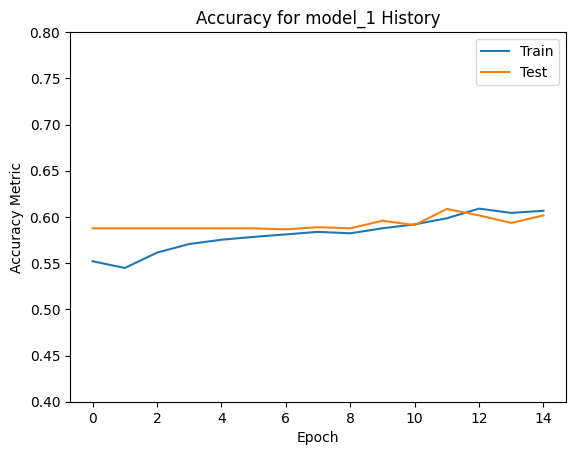

In [ ]:
plt.plot(model_res_1.history['acc'], label = 'Train')
plt.plot(model_res_1.history['val_acc'], label = 'Test')
plt.title('Accuracy for model_1 History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Metric')
plt.ylim(0.4, 0.8)
plt.legend();
plt.savefig('drive/MyDrive/data/acc_model_1.png')

## Conclusion

So far this is our best performing model but only by a fraction. Visually we can see a subtle increase in accuracy over our epochs. Similarly we can see a gradual decrease in our overall loss. So far this model has the lowest overall loss at 0.67. Although this passes our null-baseline this is still an underperforming model.

---

# VGG16 Model

The VGG16 is a transfer learning method model that has been pre trained on ImageNet. VGG16 specifically refers to a VGG model with 16 weight layers, including 13 convolutional layers and 3 fully connected layers. In this model, our spectrograms have to be processed specifically through the ImageDataGenerator. To do this we need created a new file path that directs to two folders titled train and test. In these folders consist of a major and minor folder with the same distribution as the original data source (Major: 58%, Minor: 42%). The test and train folders contain the same 75%/25% split as the other models.

In [7]:
train_path = 'drive/MyDrive/spectrograms/train'
test_path = 'drive/MyDrive/spectrograms/test'

In [8]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58889256/58889256 [==============================] - 1s 0us/step


In [9]:
# It is important to freeze the base layers so we can add our own custom layers.
for layer in base_model.layers:
    layer.trainable = False

In [10]:
vgg16_model = Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    Dropout(0.1),
    layers.Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])


In [11]:
vgg16_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
# Collecting and processing the spectrograms
train_datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary')


Found 2577 images belonging to 2 classes.


In [13]:
# Collecting and processing the spectrograms
test_datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary')

Found 859 images belonging to 2 classes.


In [14]:
vgg16_hist = vgg16_model.fit(
    train_generator, validation_data = test_generator,
    epochs=5, verbose=1)


Epoch 1/5
81/81 [==============================] - 2334s 29s/step - loss: 4.4669 - accuracy: 0.4967 - val_loss: 0.7031 - val_accuracy: 0.5239
Epoch 2/5
81/81 [==============================] - 2541s 31s/step - loss: 0.8930 - accuracy: 0.5157 - val_loss: 0.6841 - val_accuracy: 0.5856
Epoch 3/5
81/81 [==============================] - 2339s 29s/step - loss: 0.7532 - accuracy: 0.5747 - val_loss: 0.6826 - val_accuracy: 0.5856
Epoch 4/5
81/81 [==============================] - 2219s 27s/step - loss: 0.7323 - accuracy: 0.5693 - val_loss: 0.6835 - val_accuracy: 0.5844
Epoch 5/5
81/81 [==============================] - 2244s 28s/step - loss: 0.7018 - accuracy: 0.5817 - val_loss: 0.6833 - val_accuracy: 0.5844


In [19]:
vgg16_model.evaluate(test_generator)

27/27 [==============================] - 551s 20s/step - loss: 0.6827 - accuracy: 0.5844


[0.6826567053794861, 0.584400475025177]

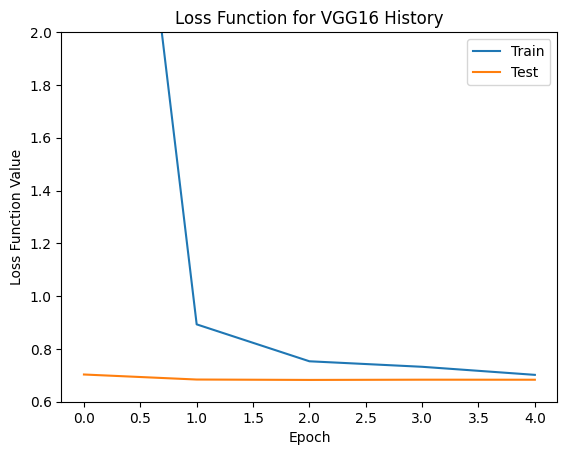

In [16]:
plt.plot(vgg16_hist.history['loss'], label = 'Train')
plt.plot(vgg16_hist.history['val_loss'], label = 'Test')
plt.title('Loss Function for VGG16 History')
plt.xlabel('Epoch')
plt.ylabel('Loss Function Value')
plt.ylim(0.6, 2)
plt.legend();
plt.savefig('drive/MyDrive/data/loss_vgg16.png')

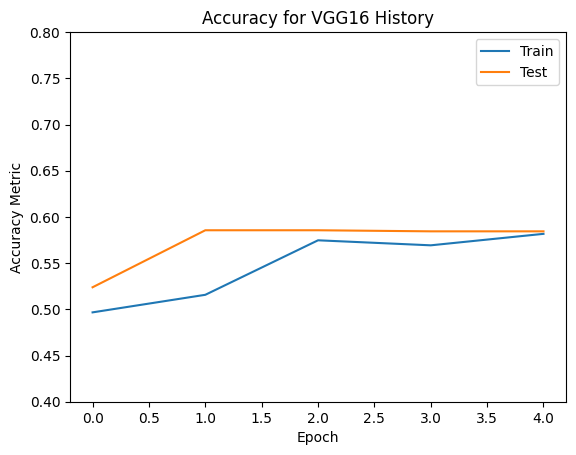

In [18]:
plt.plot(vgg16_hist.history['accuracy'], label = 'Train')
plt.plot(vgg16_hist.history['val_accuracy'], label = 'Test')
plt.title('Accuracy for VGG16 History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Metric')
plt.ylim(0.4, 0.8)
plt.legend();
plt.savefig('drive/MyDrive/data/acc_vgg16.png')

# Conclusion

Although the VGG16 model showed visual gradual signs of increasing accuracy and deacresing loss, it's accuracy of 58.4% did not perform better than our model_1 accuracy of 60.16%. Our model_1 overall loss also performed the best with 0.67 because VGG16's loss was 0.68. VGG16 has been trained on an extensive library of images. It's architecture has proven to successfully produce highly accurate image classification models. There could be many explinations for why the VGG16 model did not perform well with our spectrogram dataset.

For future considerations I would like to propose these solutions to increasing the accuracy of our VGG16 model.

- Increase the amount of audio samples from both chords and ensure there is a closer even split of classes.
- Create a large multi-class dataset of detailed categories of chord qualities. VGG16 was trained on a 1000 multi-class dataset. Using this model could have been unecessary for our binary-classification problem so increasing the classes could help fit the VGG16 better.

In [20]:
# # Loss of all validation data
# plt.plot(base.history['val_loss'], label = 'Base_Model')
# plt.plot(sc_base.history['val_loss'], label = 'Scaled_Base_Model')
# plt.plot(model_res_1.history['val_loss'], label = 'Extra_Layers_Model')
# plt.plot(vgg16_hist.history['val_loss'], label = 'VGG16_Model')
# plt.title('Loss Function for all Validation Data')
# plt.xlabel('Epoch')
# plt.ylabel('Loss Function Value')
# plt.ylim(0, 3)
# plt.legend();
# plt.savefig('drive/MyDrive/data/total_loss.png')

In [ ]:
# # Accuracy of all validation data
# plt.plot(base.history['val_acc'], label = 'Base_Model')
# plt.plot(sc_base.history['val_acc'], label = 'Scaled_Base_Model')
# plt.plot(model_res_1.history['val_acc'], label = 'Extra_Layers_Model')
# plt.plot(vgg16_hist.history['val_accuracy'], label = 'VGG16_Model')
# plt.title('Accuracy for all Validation Data')
# plt.xlabel('Epoch')
# plt.ylabel('Loss Function Value')
# plt.ylim(0, 3)
# plt.legend();
# plt.savefig('drive/MyDrive/data/total_acc.png')

# Overall Conclusion

Accuracy:

**base-model**: 60.89%

**scaled_base_model**: 58.77%

**added_layers_model**: 60.16%

**VGG16_model**: 58.44%


Loss:

**base-model**: 2.1

**scaled_base_model**: 0.75

**added_layers_model**: 0.67

**VGG16_model**: 0.68

---

In this notebook we tested scaled and unscaled spectrograms by running the same CNN structured model through both. Scaling our data using the z-score method stagnated the accuracy and loss results. For future consideration this project will aim to compare the performance of scaled and unscaled spectrogram data by running multiple iterations of CNN models through both to be able to compare a large series of results. Discovering the optimal way to format spectrogram data for a CNN model is still uncertain and this project aims to find a clear answer.

Although our added_layers_model performed the best and improved from our null_baseline, none of our models show significant clear results. There could be a number of reasons for this but two potential problems this project aims to tackle are the mislabeled class data discovered and the vague classes. After multiple random samplings of the audio files to confirm its class, I discovered some misclassified chords and unwanted chord qualities. Mislabeled data is the most obvious reason why our model could be performing poorly. For future consideration this project aims to generate our own audio data with completely correct class labels. We also aim to simplify the audio context by only recording triad chords with their respective inversions. Triad chords are much more distinguishable from one another than 7th chords. The majority of the samples listened to of the data used in this project were 7th chords causing potential overlap of chord qualities.


